## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

In [48]:
# 0.1 Importar pandas para leer los dataframes
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)

In [49]:
# 0.2 Leer el dataframe
df_amz = pd.read_csv('amz_uk_price_prediction_dataset.csv')
df_amz.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [50]:
# 1 / Crosstab Analysis:
# 1.1 / Create a crosstab between the product `category` and the `isBestSeller` status.
ct_category_isbestseller = pd.crosstab(index = df_amz["category"], columns = df_amz["isBestSeller"])
ct_category_isbestseller.head(10)

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
Agricultural Equipment & Supplies,8421,109
Alexa Built-In Devices,106,1
Art & Craft Supplies,253,5
Arts & Crafts,9319,230


In [51]:
# 1.2 / Are there categories where being a best-seller is more prevalent? 
ct_category_isbestseller["bestseller_percent"] = (100*ct_category_isbestseller[True] / (ct_category_isbestseller[True] + ct_category_isbestseller[False])).round(3)
ct_category_isbestseller.sort_values(by="bestseller_percent", ascending=False).head(10)

isBestSeller,False,True,bestseller_percent
category,,,
Grocery,9008,556,5.813
Smart Home Security & Lighting,98,6,5.769
Health & Personal Care,9017,552,5.769
Mobile Phone Accessories,248,11,4.247
Power & Hand Tools,8353,306,3.534
"Billiard, Snooker & Pool",241,8,3.213
Pet Supplies,9152,285,3.020
Home Brewing & Wine Making,239,7,2.846
Wind Instruments,243,7,2.800


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [52]:
# 2.1 / Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
import pandas as pd
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(ct_category_isbestseller)
chi2_statistic, chi2_p_value

(50603.01491727254, 0.0)

In [53]:
# Interpreting the p-value
if chi2_p_value < 0.05:
    print("\nHay una relación significativa entre la categoría del producto y si es best-seller.")
else:
    print("\nNo hay una relación significativa entre la categoría del producto y si es best-seller.")


Hay una relación significativa entre la categoría del producto y si es best-seller.


In [54]:
# 2.2 / Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association
ct_category_isbestseller_result = ct_category_isbestseller.astype(int)
cramers_v = association(ct_category_isbestseller_result, method="cramer")

# Show Cramér's V result.
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.10535784364676393


Existe una asociación débil entre el estado de best-seller y la categoría.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

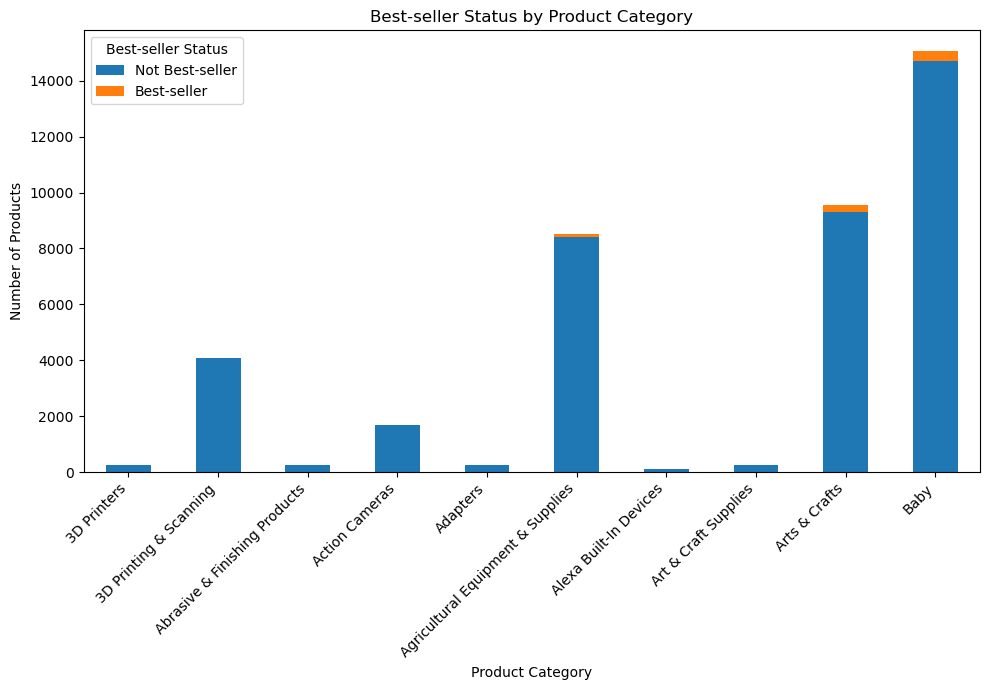

In [55]:
# 3 / Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
import pandas as pd
import matplotlib.pyplot as plt

# Visualization of the stacked bar chart
ct_category_isbestseller.head(10).plot(kind='bar', stacked=True, figsize=(10,7))

# Add labels and title
plt.title('Best-seller Status by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.legend(title='Best-seller Status', labels=['Not Best-seller', 'Best-seller'])
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.tight_layout()
plt.show()

The bar plot shows that there are more best-seller products while the number of products per category is higher.

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [56]:
# Show dataframe
df_amz.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [71]:
# 2.0
import pandas as pd

# Calculate Q1 (first quartile) and Q3 (third quartile)
Q1 = df_amz['price'].quantile(0.25)
Q3 = df_amz['price'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_amz_no_outliers = df_amz[(df_amz['price'] >= lower_bound) & (df_amz['price'] <= upper_bound)]

# View the DataFrame without outliers
df_amz_no_outliers.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

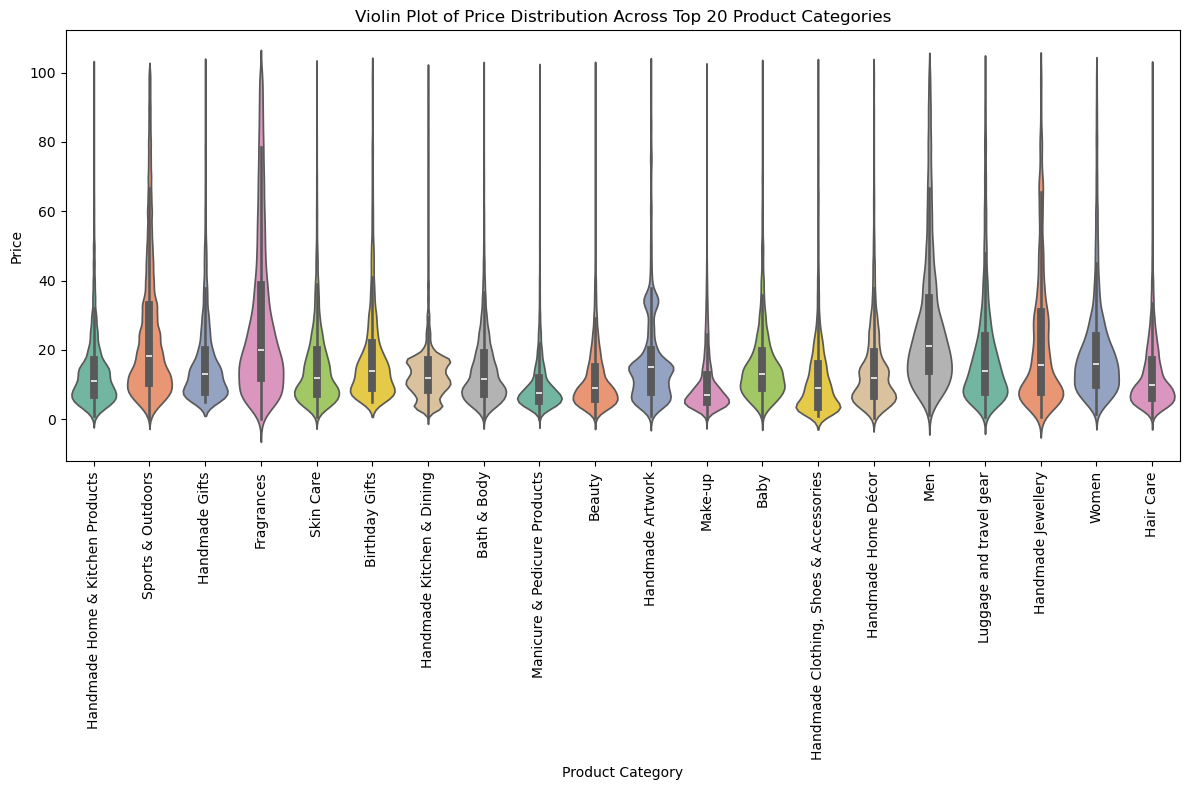

In [74]:
# 2.1.1 Use a violin plot to visualize the distribution of `price` across different product `categories`.
# Filter out the top 20 categories based on count for better visualization.
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the top 20 categories based on count
top_20_categories = df_amz_no_outliers['category'].value_counts().nlargest(20).index
df_top_20 = df_amz_no_outliers[df_amz_no_outliers['category'].isin(top_20_categories)]

# Create the violin plot for price distribution across categories, with category as hue
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='price', hue='category', data=df_top_20, palette='Set2', legend=False)

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.title('Violin Plot of Price Distribution Across Top 20 Product Categories')

# Display the plot
plt.tight_layout()
plt.show()



This violin plot shows that there are a lot of different prices per product categories. But the common prices is near 15-20 dollars.

In [75]:
# 2.1.2
# Group by 'category' and calculate the median price for each category
category_median_prices = df_amz_no_outliers.groupby('category')['price'].median()

# Find the category with the highest median price
highest_median_category = category_median_prices.idxmax()
highest_median_price = category_median_prices.max()

# Output the result
print(f"The product category with the highest median price is '{highest_median_category}' with a median price of {highest_median_price}.")


The product category with the highest median price is 'Desktop PCs' with a median price of 74.0.


2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

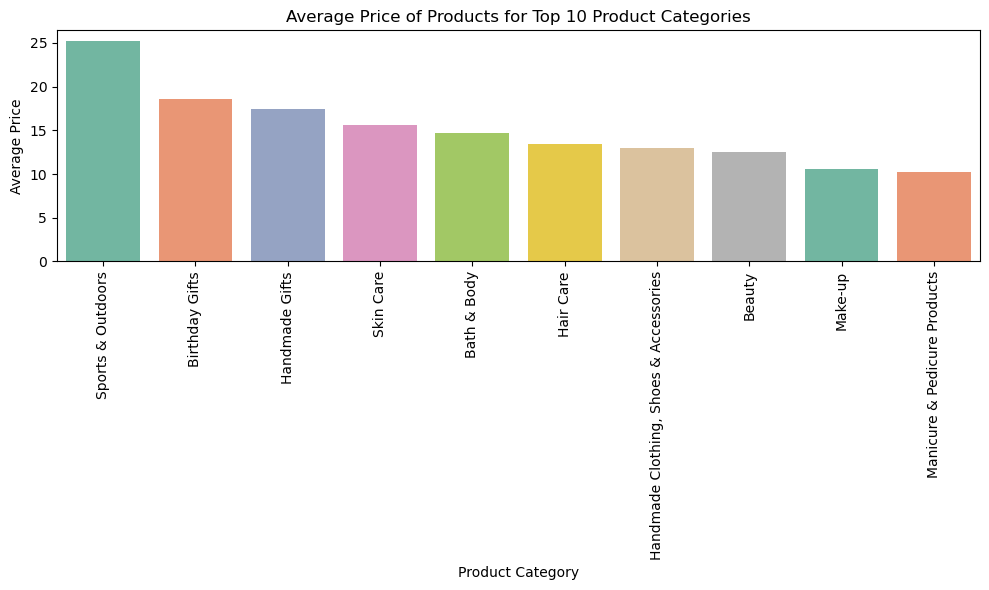

In [78]:
# 2.2.1
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the top 10 product categories based on count
top_10_categories = df_amz_no_outliers['category'].value_counts().nlargest(10).index
df_top_10 = df_amz_no_outliers[df_amz_no_outliers['category'].isin(top_10_categories)]

# Group by 'category' and calculate the average price for each category
avg_price_top_10 = df_top_10.groupby('category')['price'].mean().sort_values(ascending=False)

# Create a bar chart for the top 10 product categories based on average price
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_top_10.index, y=avg_price_top_10.values, hue=avg_price_top_10.index, palette='Set2', dodge=False, legend=False)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.title('Average Price of Products for Top 10 Product Categories')

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

It seems that the mayority average products prices in top 10 product categories is near 15 dollars.

In [77]:
# 2.2.2
# Find the category with the highest average price without filtering
category_avg_prices = df_amz_no_outliers.groupby('category')['price'].mean()
highest_avg_category = category_avg_prices.idxmax()
highest_avg_price = category_avg_prices.max()

# Output the result
print(f"The product category with the highest average price is '{highest_avg_category}' with an average price of {highest_avg_price}.")

The product category with the highest average price is 'Motherboards' with an average price of 68.77243243243242.


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

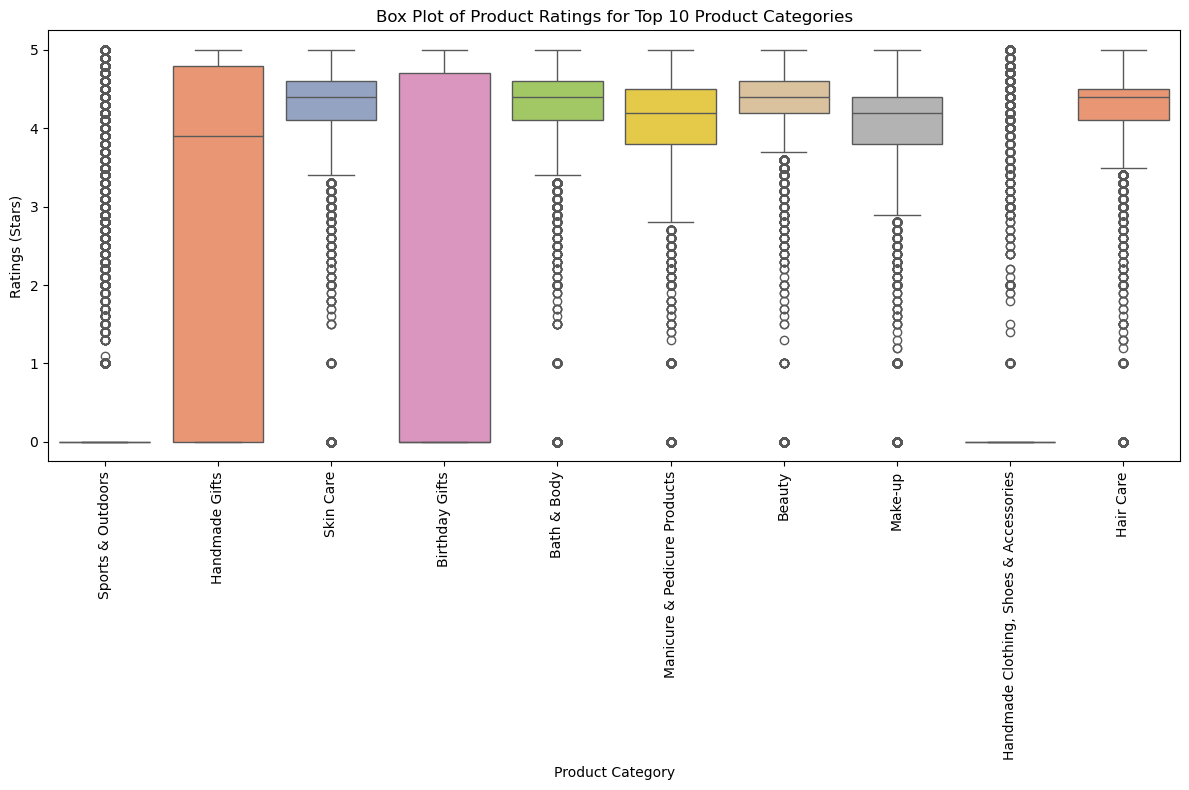

In [80]:
# 2.3.1
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the top 10 product categories based on count
top_10_categories = df_amz_no_outliers['category'].value_counts().nlargest(10).index
df_top_10 = df_amz_no_outliers[df_amz_no_outliers['category'].isin(top_10_categories)]

# Create the box plot for ratings distribution across the top 10 categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars', data=df_top_10, hue='category', palette='Set2', dodge=False, legend=False)

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Ratings (Stars)')
plt.title('Box Plot of Product Ratings for Top 10 Product Categories')

# Display the plot
plt.tight_layout()
plt.show()

It seems that the mayority of averages per category is over 4 stars.

In [81]:
# 2.3.2
# Group by 'category' and calculate the median rating for each category
category_median_ratings = df_amz_no_outliers.groupby('category')['stars'].median()

# Find the category with the highest median rating
highest_median_rating_category = category_median_ratings.idxmax()
highest_median_rating = category_median_ratings.max()

# Output the result
print(f"The product category with the highest median rating is '{highest_median_rating_category}' with a median rating of {highest_median_rating}.")


The product category with the highest median rating is 'Computer Memory' with a median rating of 4.7.


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.


1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [87]:
# 3.1.1
# Calculate the correlation coefficient between 'price' and 'stars'
correlation = df_amz_no_outliers['price'].corr(df_amz_no_outliers['stars'])

# Correlation coefficient
print(f"The correlation coefficient between price and stars is {correlation:.3f}.")

The correlation coefficient between price and stars is -0.078.


In [88]:
# 3.1.2
# Interpretation
if correlation > 0.5:
    print("There is a strong positive relationship between price and stars.")
elif correlation > 0:
    print("There is a weak positive relationship between price and stars.")
elif correlation == 0:
    print("There is no relationship between price and stars.")
elif correlation > -0.5:
    print("There is a weak negative relationship between price and stars.")
else:
    print("There is a strong negative relationship between price and stars.")

There is a weak negative relationship between price and stars.


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

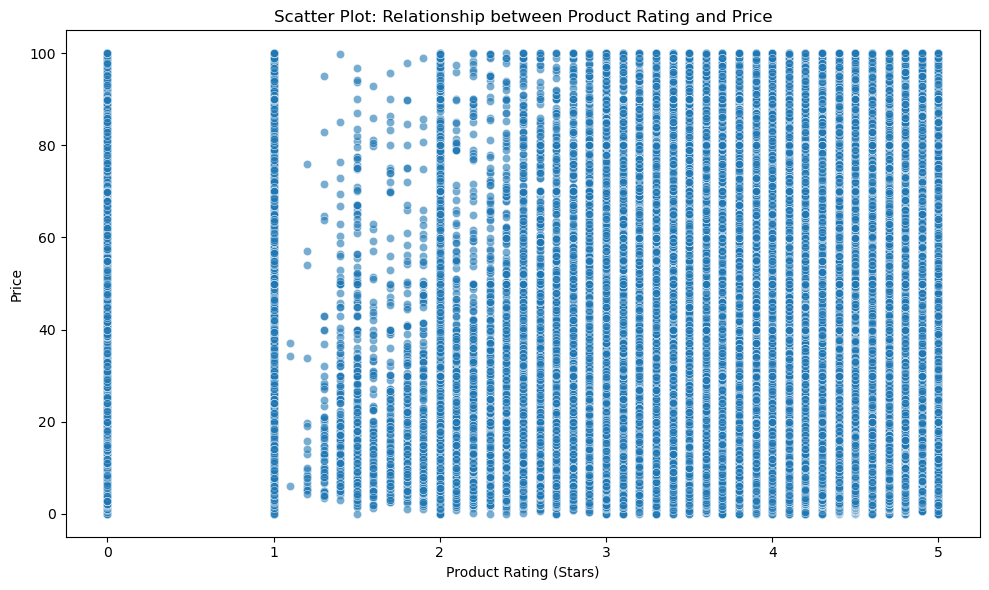

In [89]:
# 3.2.1
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to visualize the relationship between price and stars
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stars', y='price', data=df_amz_no_outliers, alpha=0.6)

# Add labels and title
plt.xlabel('Product Rating (Stars)')
plt.ylabel('Price')
plt.title('Scatter Plot: Relationship between Product Rating and Price')

# Display the plot
plt.tight_layout()
plt.show()

It seems that there are a lot of products without scoring rate.

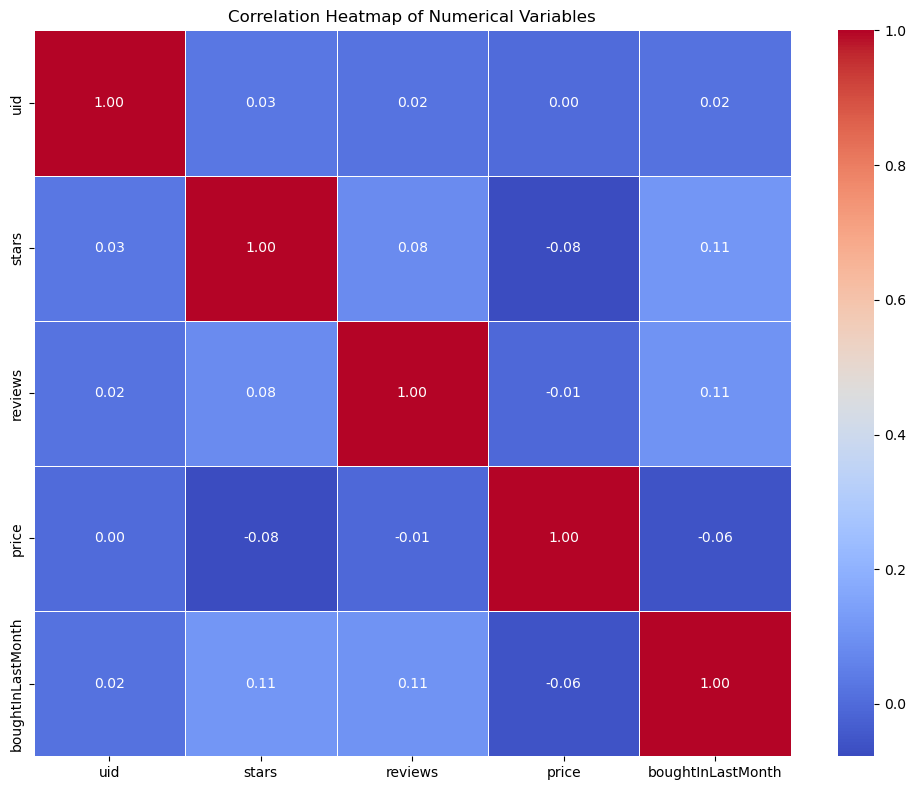

In [91]:
# 3.2.2
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numeric columns for correlation
numeric_df = df_amz_no_outliers.select_dtypes(include='number')

# Compute the correlation matrix for all numerical variables
corr_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Add title
plt.title('Correlation Heatmap of Numerical Variables')

# Display the plot
plt.tight_layout()
plt.show()


It seems that there isn't any medium or strong correlation between numerical variables.

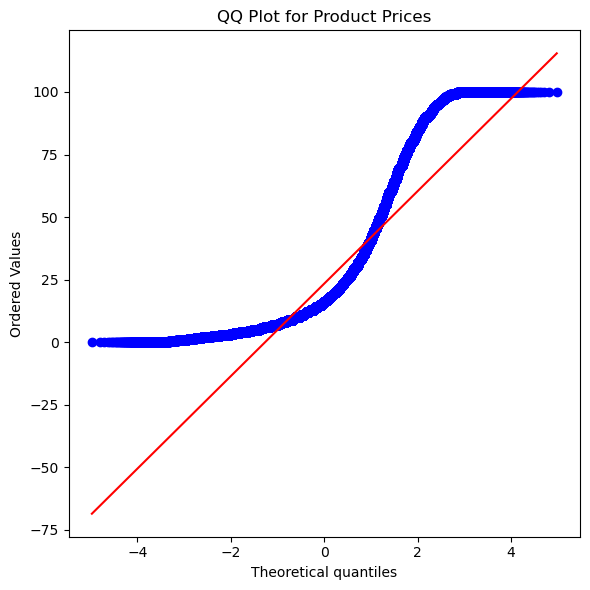

In [92]:
# 3.2.3
import scipy.stats as stats

# QQ plot to examine if product prices follow a normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(df_amz_no_outliers['price'], dist="norm", plot=plt)

# Add title
plt.title('QQ Plot for Product Prices')

# Display the plot
plt.tight_layout()
plt.show()

Conclusion of Q-Q plot: There isn't a normal distribution for product prices.